In [9]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
import admix_prs

import pandas as pd
import numpy as np

import admix
from scipy import stats
import matplotlib.pyplot as plt
from os.path import join
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [10]:
df_lanc = pd.read_csv("../02_simulation/out/admix_lanc.tsv", sep="\t", index_col=0)
df_lanc["lanc"] = 1.0 - df_lanc["lanc"]
df_lanc["lanc_q"] = pd.qcut(df_lanc.lanc, q=5).cat.codes + 1

In [11]:
trait = "height"

In [12]:
# read phenotype
PHENO_DIR = "/u/project/pasaniuc/pasaniucdata/admixture/projects/admix-prs-uncertainty/data/pheno"
df_covar = (
    pd.concat(
        [
            pd.read_csv(join(PHENO_DIR, f"{group}.covar"), delim_whitespace=True)
            for group in ["eur_test", "admix"]
        ]
    )
    .reset_index(drop=True)
    .astype({"FID": str, "IID": str})
)
df_covar.index = df_covar.FID + "_" + df_covar.IID
df_covar = df_covar[["SEX", "AGE"] + [f"PC{i}" for i in range(1, 11)]]

In [13]:
df_pheno = []
for group in ["eur_test", "admix"]:
    df_tmp = pd.read_csv(join(PHENO_DIR, f"{group}.{trait}.residual_pheno"), sep="\t")
    df_tmp.index = df_tmp.FID.astype(str) + "_" + df_tmp.IID.astype(str)
    df_tmp = df_tmp.drop(columns=["FID", "IID"])
    df_pheno.append(df_tmp)

df_pheno = (
    pd.concat(df_pheno)
    .reset_index()
    .drop_duplicates(subset=["index"])
    .set_index("index")
)

df_prs_eur_test = pd.read_csv(f"out/prs/{trait}.eur_test.tsv.gz", sep="\t", index_col=0)
df_prs_eur_test["GROUP"] = "eur_test"
df_prs_admix = pd.read_csv(f"out/prs/{trait}.admix.tsv.gz", sep="\t", index_col=0)
df_prs_admix["GROUP"] = "admix"
df_prs = pd.concat([df_prs_eur_test, df_prs_admix])
df_prs["PHENO"] = df_pheno["PHENO"].reindex(df_prs.index)

QUANTILES = [0.1, 0.9]

df_pred = df_prs[[f"SAMPLE_{i}" for i in range(1, 501)]]

pred_interval = np.quantile(df_pred, q=QUANTILES, axis=1)
pred_sd = np.std(df_pred, axis=1)
df_plot = pd.DataFrame(
    {
        "PRS_MEAN": df_prs["MEAN"],
        "PRS_SD": pred_sd,
        "GROUP": df_prs["GROUP"],
        "PHENO": df_prs["PHENO"],
    }
)

for q_i, q in enumerate(QUANTILES):
    df_plot[f"PRS_Q_{q}"] = pred_interval[q_i, :]

df_summary = pd.merge(df_plot, df_covar, left_index=True, right_index=True)

# add admixture group
df_summary_admix = df_summary[df_summary.GROUP == "admix"]
df_summary.loc[df_summary_admix.index, "GROUP"] = (
    "admix_" + df_lanc["lanc_q"].astype(str)
).reindex(df_summary_admix.index)

In [14]:
# calibrate seperately for eur_test and admix
mean_cov_cols = ["SEX", "AGE"] + [f"PC{i}" for i in range(1, 3)]
quantile_cov_cols = ["PC1", "PC2"]

for group in ["admix", "eur_test"]:
    df_tmp = df_summary[df_summary["GROUP"].str.startswith(group)].copy()
    idx_cal, idx_test = train_test_split(df_tmp.index, train_size=0.5)
    for method in [None, "shift", "scale"]:
        df_calibrated = admix_prs.calibrate_prs(
            df_tmp,
            idx_cal,
            mean_cov_cols=mean_cov_cols,
            q=0.1,
            method=method,
            quantile_cov_cols=quantile_cov_cols,
        )
        method_prefix = "CENTER" if method is None else method.upper()
        df_summary.loc[
            df_calibrated.index,
            [f"{method_prefix}_PRS_Q_0.1", f"{method_prefix}_PRS_Q_0.9"],
        ] = df_calibrated.values
    df_summary.loc[idx_cal, "IN_CAL"] = True
    df_summary.loc[idx_test, "IN_CAL"] = False


df_summary = df_summary[
    ["GROUP", "PHENO"]
    + ["IN_CAL"]
    + [col for col in df_summary.columns if "PRS_Q" in col]
]

df_summary.index.name = "INDIV"
df_summary = df_summary.reset_index()

In [15]:
df_sum = df_summary.copy()

In [16]:
df_plot = {
    "group": [],
    "coverage": [],
    "method": [],
    "R2": [],
    "avg_len": [],
}
for group, df_group in df_sum.dropna().groupby(["GROUP"]):
    df_group = df_group[df_group.IN_CAL == False]
    for method in ["CENTER", "SHIFT", "SCALE"]:
        lower = df_group[f"{method}_PRS_Q_0.1"]
        upper = df_group[f"{method}_PRS_Q_0.9"]
        center = (lower + upper) / 2
        pheno = df_group.PHENO
        coverage = np.mean((lower <= pheno) & (pheno < upper))
        df_plot["group"].append(group)
        df_plot["coverage"].append(coverage)
        df_plot["method"].append(method)
        df_plot["R2"].append(pearsonr(center, pheno)[0] ** 2)
        df_plot["avg_len"].append(np.mean(upper - lower))

df_plot = pd.DataFrame(df_plot)

In [17]:
import seaborn as sns

Text(0, 0.5, 'Empirical coverage')

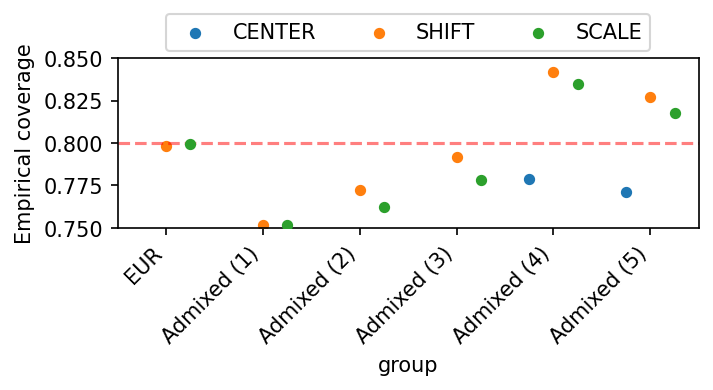

In [18]:
fig, ax = plt.subplots(figsize=(5, 1.5), dpi=150)
sns.pointplot(
    x="group",
    y="coverage",
    order=["eur_test"] + [f"admix_{i}" for i in range(1, 6)],
    hue="method",
    dodge=0.5,
    data=df_plot,
    errwidth=1.5,
    capsize=0.2,
    markers=".",
    join=False,
    ax=ax,
)
ax.axhline(y=0.8, ls="--", color="red", alpha=0.5)
ax.set_ylim(0.75, 0.85)
ax.set_xticklabels(
    ["EUR"] + [f"Admixed ({i})" for i in range(1, 6)], rotation=45, ha="right"
)
ax.legend(loc="center", bbox_to_anchor=(0.5, 1.15), ncol=3)
ax.set_ylabel("Empirical coverage")

Text(0, 0.5, '$R^2$')

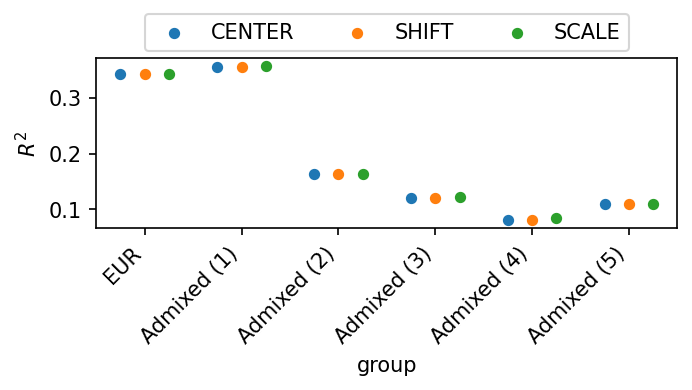

In [19]:
fig, ax = plt.subplots(figsize=(5, 1.5), dpi=150)
sns.pointplot(
    x="group",
    y="R2",
    order=["eur_test"] + [f"admix_{i}" for i in range(1, 6)],
    hue="method",
    dodge=0.5,
    data=df_plot,
    errwidth=1.5,
    capsize=0.2,
    markers=".",
    join=False,
    ax=ax,
)
ax.set_xticklabels(
    ["EUR"] + [f"Admixed ({i})" for i in range(1, 6)], rotation=45, ha="right"
)
ax.legend(loc="center", bbox_to_anchor=(0.5, 1.15), ncol=3)
ax.set_ylabel("$R^2$")

Text(0, 0.5, 'Interval length')

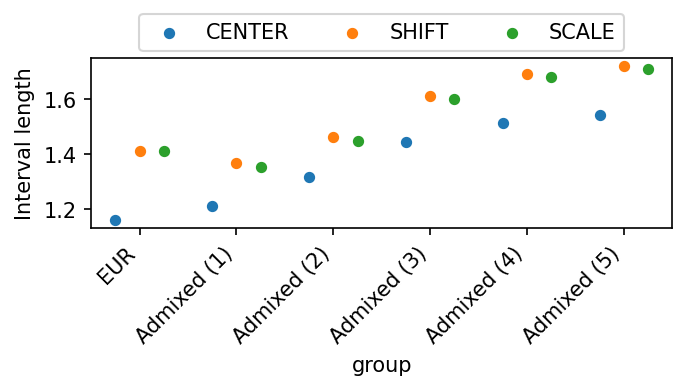

In [20]:
fig, ax = plt.subplots(figsize=(5, 1.5), dpi=150)
sns.pointplot(
    x="group",
    y="avg_len",
    order=["eur_test"] + [f"admix_{i}" for i in range(1, 6)],
    hue="method",
    dodge=0.5,
    data=df_plot,
    errwidth=1.5,
    capsize=0.2,
    markers=".",
    join=False,
    ax=ax,
)
ax.set_xticklabels(
    ["EUR"] + [f"Admixed ({i})" for i in range(1, 6)], rotation=45, ha="right"
)
ax.legend(loc="center", bbox_to_anchor=(0.5, 1.15), ncol=3)
ax.set_ylabel("Interval length")

In [16]:
df_plot_group = {"group": [], "R2": [], "avg_prs_sd": []}

for i, group in df_plot.groupby("lanc_q"):
    df_plot_group["group"].append(i)
    df_plot_group["R2"].append(
        stats.pearsonr(group["PRS_MEAN"], group["PHENO"])[0] ** 2
    )
    df_plot_group["avg_prs_sd"].append(group["PRS_SD"].mean())
df_plot_group = pd.DataFrame(df_plot_group)

KeyError: 'lanc_q'